# Statistics by zones

> Descriptive statistical analysis and visualization using box plots for the zones:
> - FWL (Freshwater Lens): $x < A$
> - MZ (Mixing Zone): $A \leq x \leq B$
> - SZ (Saline Zone): $x > B$
> 
> The zones were delimited using the `dgh` method
 
### Table of contents
  
1. Import libraries and initial setup
2. Load data with breakpoints
3. Descriptive statistical analysis
4. Visualization using box plots for each zone



---

### Import libraries and initial setup

In [1]:
import os
import sys
import warnings

root = os.path.abspath('../..')  
sys.path.append(root)
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from typing import Tuple, Optional, Any, Dict, List

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import modules.statistics_fwl_estimation as st_fwl

from modules import processing, load, plots, analysis


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 25)

---

## Load breakpoint estimation data

In [2]:
path_dgh = f'{root}/data/dgh_fwl_estimation.csv'

df_dgh = pd.read_csv(path_dgh)

df_dgh = df_dgh[['ID', 'breakpoint_1 (vp)', 'breakpoint_2 (vp)']]

df_dgh


,ID,breakpoint_1 (vp),breakpoint_2 (vp)
0,AW1D_YSI_20230826,16.386594,21.442094
1,AW2D_YSI_20230815,11.319882,NaN
2,AW5D_YSI_20230824,12.090368,23.999913
3,AW6D_YSI_20230815,13.844801,21.420759
4,AW7D_YSI_20230814,13.316418,25.752851
5,BW10D_YSI_20230825,11.276226,21.648532
6,BW11D_YSI_20230823,11.645055,16.667353
7,BW1D_YSI_20230824,14.117028,22.376200
8,BW2D_YSI_20230819,14.581115,24.051731
9,BW3D_YSI_20230818,12.974280,20.804204


#### Asignar breakpoint_2 (vp) para AW2D_YSI_20230815 como el último punto.

In [3]:
df_aw2d = pd.read_csv(f'{root}/data/rawdy/AW2D_YSI_20230815_rowdy.csv')

# Asignar el último punto de `ID` = AW2D_YSI_20230815 a breakpoint_2 (vp)
df_dgh.loc[df_dgh['ID'] == 'AW2D_YSI_20230815', 'breakpoint_2 (vp)'] = df_aw2d['Vertical Position [m]'].iloc[-1]

df_dgh.head(2)

,ID,breakpoint_1 (vp),breakpoint_2 (vp)
0,AW1D_YSI_20230826,16.386594,21.442094
1,AW2D_YSI_20230815,11.319882,16.046000


---

## Filter data to delimit zones

In [4]:
def filter_rowdy_data(path_data, df_dgh, seawater_ec=55600, tolerance=0.1):
    """
    Filters rowdy.csv files based on df_dgh breakpoints into three zones:
    FWL, MZ and SZ. Also validates profiles based on maximum EC value.
    
    Parameters:
    -----------
    path_data : str
        Path to the data directory.
    df_dgh : pandas.DataFrame
        DataFrame with columns ID, breakpoint_1 (vp), breakpoint_2 (vp).
    seawater_ec : float, optional
        Reference seawater electrical conductivity in μS/cm. Default is 55600.
    tolerance : float, optional
        Tolerance margin for seawater EC validation (0.1 = 10%). Default is 0.1.
        
    Returns:
    --------
    tuple
        (results, excluded_profiles)
        - results: Dictionary with ID as key and dictionary with filtered arrays for FWL, MZ and SZ.
        - excluded_profiles: Dictionary with excluded profiles and their maximum EC values.
    """
    results = {}
    excluded_profiles = {}
    
    # Calculate acceptable EC range
    min_ec = seawater_ec * (1 - tolerance)
    max_ec = seawater_ec * (1 + tolerance)
    
    for _, row in df_dgh.iterrows():
        id_val = row['ID']
        bp1_vp = row['breakpoint_1 (vp)']
        bp2_vp = row['breakpoint_2 (vp)']
        
        filename = f"{id_val}_rowdy.csv"
        filepath = os.path.join(path_data, filename)
        
        if os.path.exists(filepath):
            df_rowdy = pd.read_csv(filepath)
            
            df_rowdy.columns = [col.strip() for col in df_rowdy.columns]
            
            if 'Vertical Position [m]' in df_rowdy.columns and 'Corrected sp Cond [uS/cm]' in df_rowdy.columns:
                # Check if the profile meets the seawater EC criterion
                max_ec_value = df_rowdy['Corrected sp Cond [uS/cm]'].max()
                
                if max_ec_value < min_ec or max_ec_value > max_ec:
                    # Profile doesn't meet the criterion, exclude it
                    excluded_profiles[id_val] = {
                        'max_ec': max_ec_value,
                        'reason': f"Maximum EC ({max_ec_value:.2f} μS/cm) outside acceptable range ({min_ec:.2f} - {max_ec:.2f} μS/cm)"
                    }
                    continue
                
                # Filter FWL zone (below breakpoint_1)
                fwl_mask = df_rowdy['Vertical Position [m]'] < bp1_vp
                fwl_data = df_rowdy[fwl_mask][['Vertical Position [m]', 'Corrected sp Cond [uS/cm]']].values
                
                # Filter MZ zone (between breakpoint_1 and breakpoint_2)
                mz_mask = (df_rowdy['Vertical Position [m]'] >= bp1_vp) & (df_rowdy['Vertical Position [m]'] <= bp2_vp)
                mz_data = df_rowdy[mz_mask][['Vertical Position [m]', 'Corrected sp Cond [uS/cm]']].values
                
                # Filter SZ zone (above breakpoint_2)
                sz_mask = df_rowdy['Vertical Position [m]'] > bp2_vp
                sz_data = df_rowdy[sz_mask][['Vertical Position [m]', 'Corrected sp Cond [uS/cm]']].values
                
                results[id_val] = {
                    'FWL': fwl_data,
                    'MZ': mz_data,
                    'SZ': sz_data
                }
            else:
                print(f"File {filename} does not have expected columns.")
        else:
            print(f"File {filename} not found")
    
    return results, excluded_profiles

In [5]:
zones, excluded_wells = filter_rowdy_data(
                        f'{root}/data/rawdy', 
                        df_dgh=df_dgh,
                        seawater_ec=55600, # uS/cm
                        tolerance=0.1 # 10%
            )

excluded_wells

{'AW1D_YSI_20230826': {'max_ec': np.float64(45891.4),
  'reason': 'Maximum EC (45891.40 μS/cm) outside acceptable range (50040.00 - 61160.00 μS/cm)'},
 'AW2D_YSI_20230815': {'max_ec': np.float64(7761.7),
  'reason': 'Maximum EC (7761.70 μS/cm) outside acceptable range (50040.00 - 61160.00 μS/cm)'},
 'AW5D_YSI_20230824': {'max_ec': np.float64(47594.73571428571),
  'reason': 'Maximum EC (47594.74 μS/cm) outside acceptable range (50040.00 - 61160.00 μS/cm)'},
 'AW6D_YSI_20230815': {'max_ec': np.float64(36355.7),
  'reason': 'Maximum EC (36355.70 μS/cm) outside acceptable range (50040.00 - 61160.00 μS/cm)'},
 'AW7D_YSI_20230814': {'max_ec': np.float64(48613.4),
  'reason': 'Maximum EC (48613.40 μS/cm) outside acceptable range (50040.00 - 61160.00 μS/cm)'},
 'BW2D_YSI_20230819': {'max_ec': np.float64(33778.575),
  'reason': 'Maximum EC (33778.57 μS/cm) outside acceptable range (50040.00 - 61160.00 μS/cm)'}}

---

## Calcular estadísticas descriptivas

In [6]:
def calculate_statistics(filter_results, excluded_profiles=None):
    """
    Calculate basic statistics for filtered data.
    
    Parameters:
    -----------
    filter_results : dict
        Dictionary with filtered results.
    excluded_profiles : dict, optional
        Dictionary with excluded profiles and reasons.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with basic statistics by zone and ID.
    """
    # List to store DataFrame rows
    stats_rows = []
    
    # Iterate over each ID and its data
    for id_val, zones_data in filter_results.items():
        for zone, data in zones_data.items():
            # Extract conductivity values (second column)
            cond_values = data[:, 1]
            
            if len(cond_values) > 0:
                # Calculate quartiles
                q1 = np.percentile(cond_values, 25)
                q2 = np.percentile(cond_values, 50)  # Median
                q3 = np.percentile(cond_values, 75)
                iqr_val = q3 - q1
                
                # Identify outliers using IQR method
                lower_bound = q1 - 1.5 * iqr_val
                upper_bound = q3 + 1.5 * iqr_val
                outliers = np.sum((cond_values < lower_bound) | (cond_values > upper_bound))
                
                # Calculate coefficient of variation (CV)
                mean_val = np.mean(cond_values)
                std_val = np.std(cond_values)
                cv_val = (std_val / mean_val) * 100 if mean_val != 0 else np.nan
                
                # Calculate zone thickness (max depth - min depth)
                depth_values = data[:, 0]
                thickness = np.max(depth_values) - np.min(depth_values) if len(depth_values) > 0 else 0
                
                # Create row with statistics
                stats_row = {
                    'ID': id_val,
                    'Zone': zone,
                    'mean': mean_val,
                    'std': std_val,
                    'cv': cv_val,
                    'min': np.min(cond_values),
                    'max': np.max(cond_values),
                    'median': q2,
                    '25%': q1,
                    '50%': q2,
                    '75%': q3,
                    'iqr': iqr_val,
                    'count': len(cond_values),
                    'outliers': outliers,
                    'thickness': thickness,
                    'excluded': False  # Por defecto, no está excluido
                }
                
                stats_rows.append(stats_row)
    
    if excluded_profiles:
        for id_val, info in excluded_profiles.items():
            # Crear una fila para cada perfil excluido
            excluded_row = {
                'ID': id_val,
                'Zone': 'N/A',  
                'mean': np.nan,
                'std': np.nan,
                'cv': np.nan,
                'min': np.nan,
                'max': np.nan,
                'median': np.nan,
                '25%': np.nan,
                '50%': np.nan,
                '75%': np.nan,
                'iqr': np.nan,
                'count': 0,
                'outliers': 0,
                'thickness': 0,
                'excluded': True,  # Marcado como excluido
                'exclusion_reason': info.get('reason', 'Unknown reason')
            }
            stats_rows.append(excluded_row)
    
    # Create DataFrame with statistics
    stats_df = pd.DataFrame(stats_rows)
    
    return stats_df


In [7]:
df_stats_zones = calculate_statistics(
                    filter_results=zones,
                    excluded_profiles=excluded_wells
            )


df_stats_zones

,ID,Zone,mean,std,cv,min,max,median,25%,50%,75%,iqr,count,outliers,thickness,excluded,exclusion_reason
0,BW10D_YSI_20230825,FWL,1384.473444,183.344775,13.242925,1275.900000,2036.700000,1297.100,1288.275000,1297.100,1358.387500,70.112500,2256,427,11.269,False,NaN
1,BW10D_YSI_20230825,MZ,17065.919896,17566.681664,102.934279,2039.000000,52007.500000,6259.950,5361.600000,6259.950,38225.000000,32863.400000,2696,0,10.362,False,NaN
2,BW10D_YSI_20230825,SZ,52221.579743,153.528490,0.293994,52009.600000,52634.700000,52148.400,52135.375000,52148.400,52225.425000,90.050000,1564,287,6.778,False,NaN
3,BW11D_YSI_20230823,FWL,498.365316,45.511635,9.132184,456.900000,637.200000,476.800,464.400000,476.800,508.600000,44.200000,1879,178,11.638,False,NaN
4,BW11D_YSI_20230823,MZ,14572.707341,17328.990333,118.914008,637.600000,47820.600000,3091.550,1365.925000,3091.550,32947.800000,31581.875000,722,0,5.016,False,NaN
5,BW11D_YSI_20230823,SZ,50850.197195,1128.337448,2.218944,47858.600000,52274.820000,51422.550,49755.250000,51422.550,51851.200000,2095.950000,1062,0,6.193,False,NaN
6,BW1D_YSI_20230824,FWL,3032.712302,230.916251,7.614183,2467.900000,3544.350000,3031.900,3019.200000,3031.900,3042.000000,22.800000,1937,769,14.108,False,NaN
7,BW1D_YSI_20230824,MZ,32459.177740,13348.386710,41.123613,3546.000000,51003.600000,35844.200,21982.175000,35844.200,43344.925000,21362.750000,1612,0,8.246,False,NaN
8,BW1D_YSI_20230824,SZ,52652.811838,556.137050,1.056234,51018.200000,53353.550000,52803.200,52287.950000,52803.200,53140.800000,852.850000,1181,0,6.151,False,NaN
9,BW3D_YSI_20230818,FWL,970.608611,645.226975,66.476535,488.800000,4324.100000,528.300,515.500000,528.300,1421.125000,905.625000,1948,48,12.940,False,NaN


#### Save *(Optional)*

In [8]:
# Descomentar si es necesario
# df_stats_zones.to_csv(f'{root}/data/stats_zones.csv', index=False)

---

## Boxplots by zone

In [9]:
def generate_zone_boxplots(
    filtered_results: Dict[str, Dict[str, np.ndarray]],
    zones_to_show: Optional[List[str]] = None,
    show_outliers: bool = True,
    order: Optional[List[str]] = None,
    legend_x: float = 1.02,
    legend_y: float = 1.0,
    mirror_top_axis: bool = False,
    enable_minor_ticks: bool = False,
    draw_vertical_line: bool = False,
    vertical_line_value: float = None,
    figsize: Tuple[int, int] = None,
    excluded_profiles: Optional[Dict[str, Dict[str, str]]] = None
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Generates horizontal boxplots for specific conductivity by ID and zone.

    Args:
        filtered_results: Nested dictionary containing filtered data
            - First key: Well ID
            - Second key: Zone ('FWL', 'MZ', 'SZ')
        zones_to_show: List of zones to display (e.g. ['FWL', 'MZ', 'SZ'])
            If not provided, shows all available zones
        show_outliers: Whether to show outliers in boxplots
        order: List defining well ID order on Y axis
            IDs not in list will be ignored
            If not provided, uses natural order from filtered_results
        legend_x: X position to anchor legend
        legend_y: Y position to anchor legend  
        legend_orientation: Legend orientation - 'vertical' or 'horizontal'
        mirror_top_axis: If True, adds mirrored X axis on top
        enable_minor_ticks: If True, enables minor ticks every 1000 units
        draw_vertical_line: If True, draws vertical dotted line
        vertical_line_value: X value for vertical line (only if draw_vertical_line is True)
        figsize: Custom figure size (width, height)
        excluded_profiles: Dictionary of profiles to exclude from the plot

    Returns:
        Figure and Axes objects from Matplotlib
    """
    zone_colors = {
        'FWL': 'green',
        'MZ': 'blue', 
        'SZ': 'red'
    }

    variable = 'Corrected sp Cond [uS/cm]'

    # Collect data in list of tuples (id, zone, values)
    plot_data = []
    for id_val, zones_dict in filtered_results.items():
        # Skip excluded profiles
        if excluded_profiles and id_val in excluded_profiles:
            continue
            
        for zone, data in zones_dict.items():
            # Skip excluded zones for this profile
            if (excluded_profiles and id_val in excluded_profiles and 
                zone in excluded_profiles[id_val]):
                continue
                
            if data.shape[0] > 0:
                values = data[:, 1]  # Column 1 contains conductivity values
                # Calculate thickness (last depth - first depth)
                thickness = data[-1, 0] - data[0, 0]
                plot_data.append((id_val, zone, values, thickness))

    # Filter by zones_to_show if provided
    if zones_to_show is not None:
        plot_data = [item for item in plot_data if item[1] in zones_to_show]

    # Filter and reorder by order list if provided
    if order is not None:
        order_index = {well: i for i, well in enumerate(order)}
        plot_data = [item for item in plot_data if item[0] in order_index]
        plot_data.sort(key=lambda x: order_index[x[0]])

    # Build final lists for plotting
    group_labels = []
    group_data = []
    zone_list = []
    thickness_list = []

    for id_val, zone, values, thickness in plot_data:
        label = f"{id_val} - {zone}"
        group_labels.append(label)
        group_data.append(values)
        zone_list.append(zone)
        thickness_list.append(thickness)

    # Create figure and axes
    if figsize is None:
        figsize = (12, len(group_labels) * 0.5 + 2)
    
    fig, ax = plt.subplots(figsize=figsize)

    box_positions = np.arange(len(group_labels))
    sym = 'o' if show_outliers else ''
    used_zones = set()

    # Create boxplots grouped by zone
    unique_zones = sorted(set(zone_list))
    for zone in unique_zones:
        zone_positions = []
        zone_data = []
        for i, (lbl, dat, z) in enumerate(zip(group_labels, group_data, zone_list)):
            if z == zone:
                zone_positions.append(i)
                zone_data.append(dat)

        if zone_positions:
            color = zone_colors.get(zone, 'gray')
            bp = ax.boxplot(
                zone_data,
                positions=zone_positions,
                sym=sym,
                vert=False,
                widths=0.6,
                patch_artist=True
            )

            # Style boxplots
            for box in bp['boxes']:
                box.set(color=color, facecolor=color, alpha=0.7)
            for whisker in bp['whiskers']:
                whisker.set(color=color)
            for cap in bp['caps']:
                cap.set(color=color)
            for median in bp['medians']:
                median.set(color='black')
            for flier in bp['fliers']:
                flier.set(marker='o', markerfacecolor=color, markersize=5, alpha=0.7)

            if zone not in used_zones:
                ax.plot([], [], color=color, label=zone)
                used_zones.add(zone)

    def _calculate_outliers(data):
        """Calculate number of outliers using IQR method"""
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = sum((data < lower_bound) | (data > upper_bound))
        return outliers

    # Add n, out and thickness annotations
    for i, (data, thickness) in enumerate(zip(group_data, thickness_list)):
        n_points = len(data)
        n_outliers = _calculate_outliers(data)
        annotation_text = f"n={n_points}, out={n_outliers}, t={thickness:.3f}"
        x_max = ax.get_xlim()[1]
        ax.text(x_max * 1.05, i, annotation_text,
                verticalalignment='center', fontsize=10)

    # Configure axes and labels
    ax.set_yticks(box_positions)
    ax.set_yticklabels(group_labels)
    ax.set_xlabel('Corrected sp Cond [uS/cm]')
    ax.set_ylabel("Well ID - Zone")
    ax.set_title("Boxplots of Specific Conductivity by Well ID and Zone",
                pad=20, y=1.01)

    ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.7)

    if enable_minor_ticks:
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1000))
        ax.grid(True, which='minor', axis='x', linestyle=':', alpha=0.2)

    if draw_vertical_line and vertical_line_value is not None:
        ax.axvline(x=vertical_line_value, color='black', linestyle='--', 
                   label=f'x = {vertical_line_value}')

    if mirror_top_axis:
        ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)

    plt.subplots_adjust(right=0.75)

    legend_loc = 'upper right' if legend_x > 0.5 else 'upper left'
    ax.legend(
        loc=legend_loc,
        bbox_to_anchor=(legend_x, legend_y),
        frameon=True,
        framealpha=0.8,
        title="Zone"
    )
    
    if excluded_profiles:
        excluded_ids = list(excluded_profiles.keys())
        excluded_text = "Excluded wells:\n" + "\n".join(excluded_ids)
        # Colocar la anotación en la esquina inferior izquierda
        plt.figtext(0.025, -0.01, excluded_text, fontsize=8, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    fig.tight_layout()

    return fig, ax

> Modify the order of profiles as needed.

> **IMPORTANT**: Removing the name of a profile will make it not appear in the graph.

In [10]:
# From bottom to top in the graph.

order_plot = [
    "LRS70D_YSI_20230822", 
    "BW9D_YSI_20230823", 
    "BW11D_YSI_20230823",
    "BW8D_YSI_20230823",
    "LRS81D_YSI_20230823",
    "BW1D_YSI_20230824",
    "LRS79D_YSI_20230827",
    "AW1D_YSI_20230826",
    "LRS90D_YSI_20230827",
    "AW2D_YSI_20230815",
    "AW5D_YSI_20230824",
    "BW2D_YSI_20230819",
    "LRS75D_YSI_20230819",
    "LRS89D_YSI_20230825",
    'LRS65D_YSI_20220812',
    "AW7D_YSI_20230814",
    "AW6D_YSI_20230815",
    "BW3D_YSI_20230818",
    "BW10D_YSI_20230825",
    "BW6D_YSI_20230826",
    "BW4D_YSI_20230816",
    "LRS69D_YSI_20230818",
    "LRS33D_YSI_20230822",
    "BW7D_YSI_20230826",
    "BW5D_YSI_20230822" 
]

### Generate the graph

> **IMPORTANT**The parameter `zone_to_show` controls which zones are displayed in the graph. These are the alternatives.

1. `['SZ']`: Only for the Salt Zone
2. `['MZ']`: Only for the Mixing Zone
3. `['FWL']`: Only for the Freshwater Zone
5. `['SZ', 'MZ']`: Salt Zone and Mixing Zone
6. `['MZ', 'FWL']`: Mixing Zone and Freshwater Zone
7. `['SZ', 'FWL']`: Salt Zone and Freshwater Zone
8. `['SZ', 'MZ', 'FWL']`: All zones. The order of the list is the order of deployment.


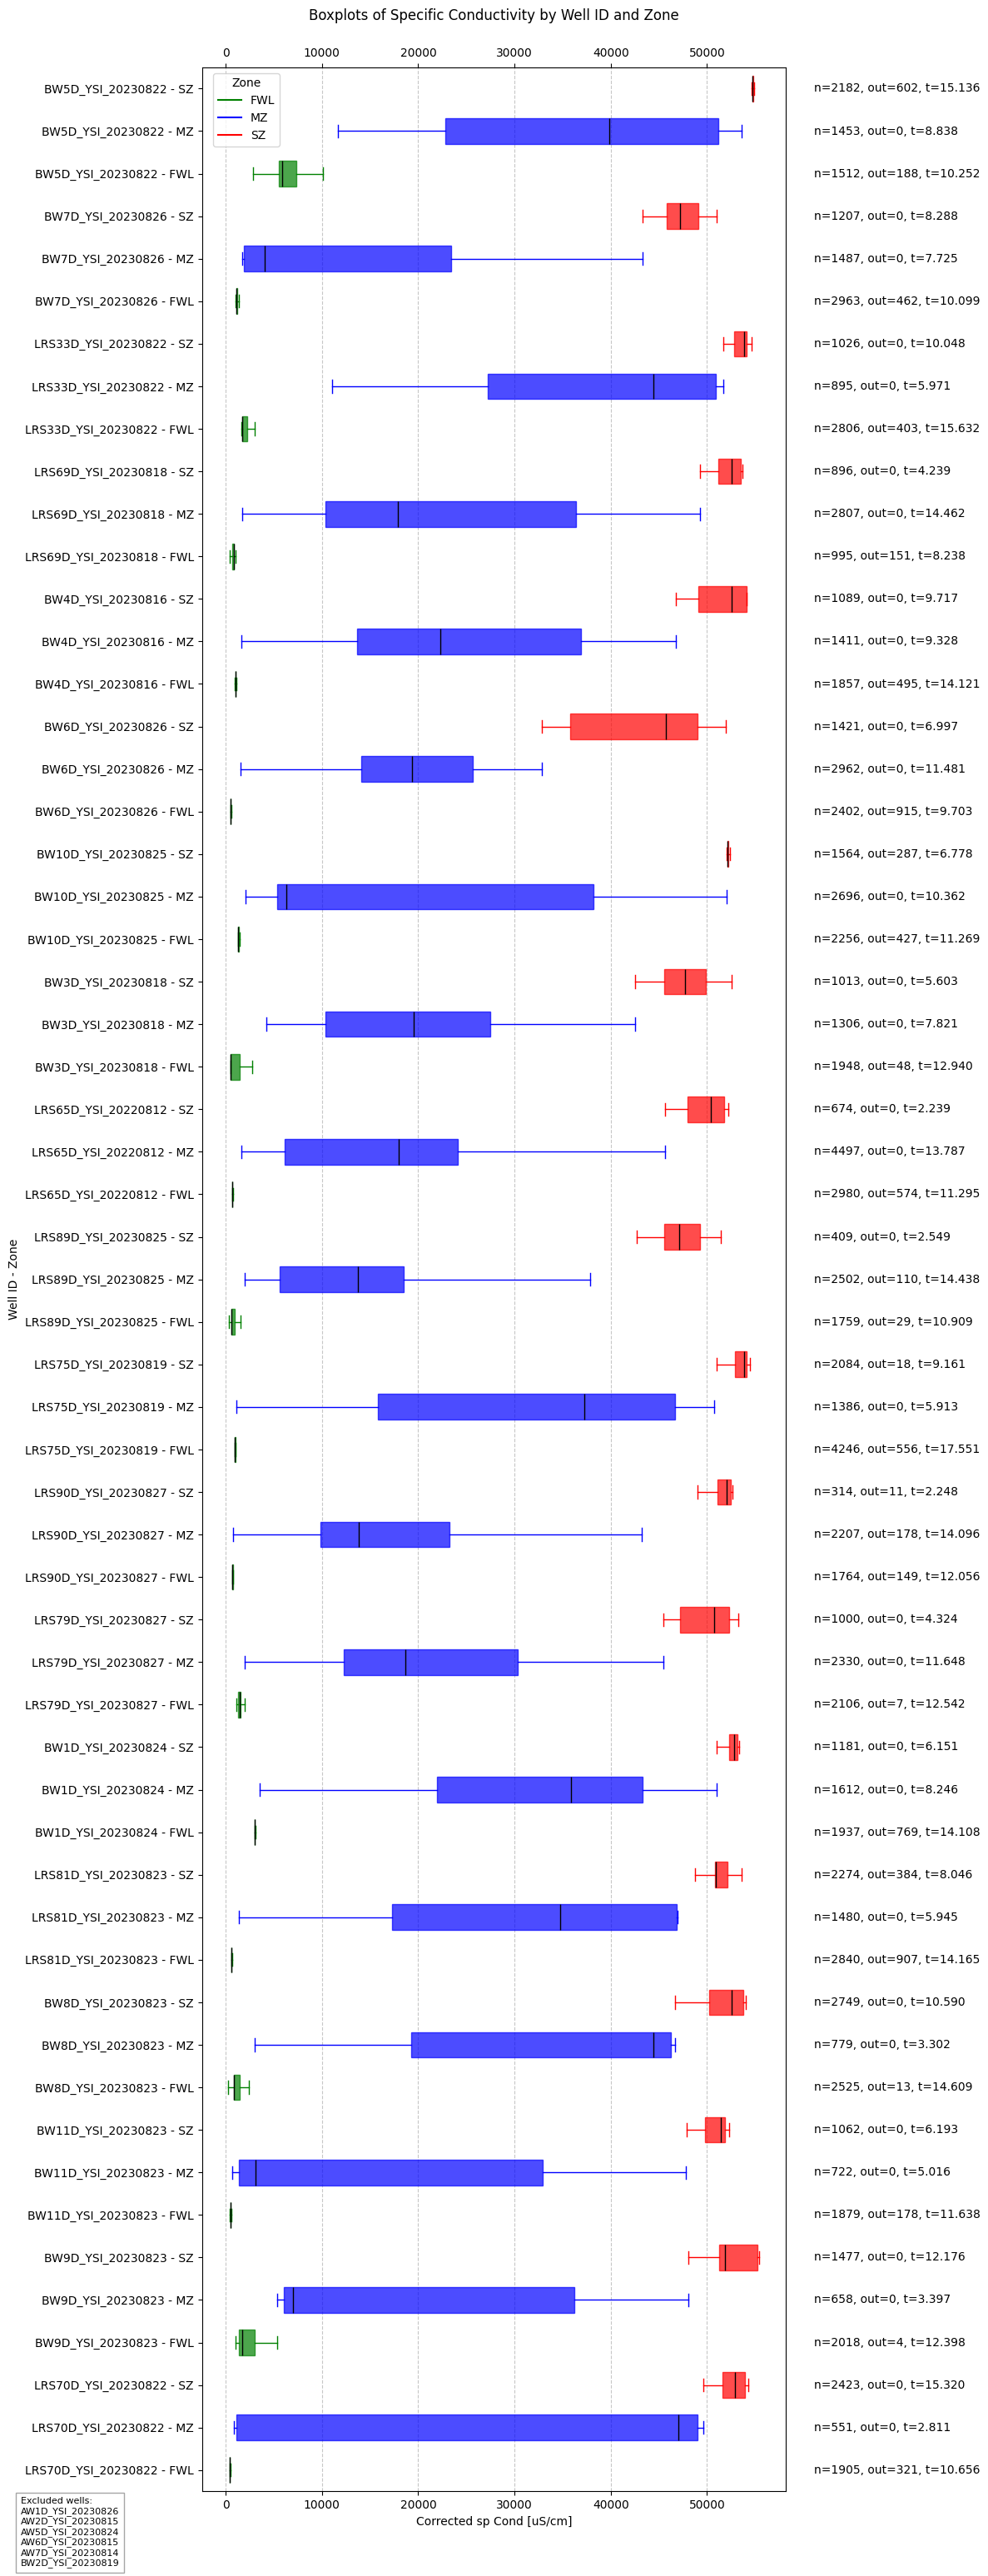

In [11]:
fig, ax = generate_zone_boxplots(filtered_results=zones,
                            zones_to_show=['SZ', 'MZ', 'FWL'],
                            show_outliers=False,
                            order=order_plot,
                            # enable_minor_ticks=True
                            mirror_top_axis=True,
                            legend_x=0.01,
                            legend_y=1.0,
                            excluded_profiles=excluded_wells
                            )

fig.show()